In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
!pip install efficientnet_pytorch torchsummary

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=26b49cf0ba083682c99529ee6f0cec2700bf4f9e0a2addb586bb0085ec7ed130
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
# cd kaggle

In [4]:
%cd ..

/kaggle


In [5]:
!ls input/butterfly-image-classification

Testing_set.csv  Training_set.csv  test  train


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import cv2
import os
from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder
from torchmetrics import F1Score

from torchsummary import summary
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report,ConfusionMatrixDisplay

In [9]:
## Global Variables
IMAGE_SIZE = 224 
BATCH_SIZE = 128
NUM_EPOCHS = 60
BASE_PATH = "input/butterfly-image-classification/"
TRAIN_IMAGE_PATH = "input/butterfly-image-classification/train/"
NUM_CLASSES = 75
LR = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
os.listdir(BASE_PATH)

['Training_set.csv', 'Testing_set.csv', 'test', 'train']

In [67]:
train_df = pd.read_csv(BASE_PATH+"Training_set.csv")
train_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [68]:
print(f"There are {train_df.shape[0] } Images in our training set")

There are 6499 Images in our training set


In [69]:
test_df = pd.read_csv(BASE_PATH+"Testing_set.csv")
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

In [70]:
print(f"There are {test_df.shape[0] } Images in our training set")

There are 2786 Images in our training set


## Exploring Training Set

In [71]:
train_df['label'].value_counts()

label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64

In [72]:
print(f"Number of Labels is {train_df['label'].nunique()}")

Number of Labels is 75


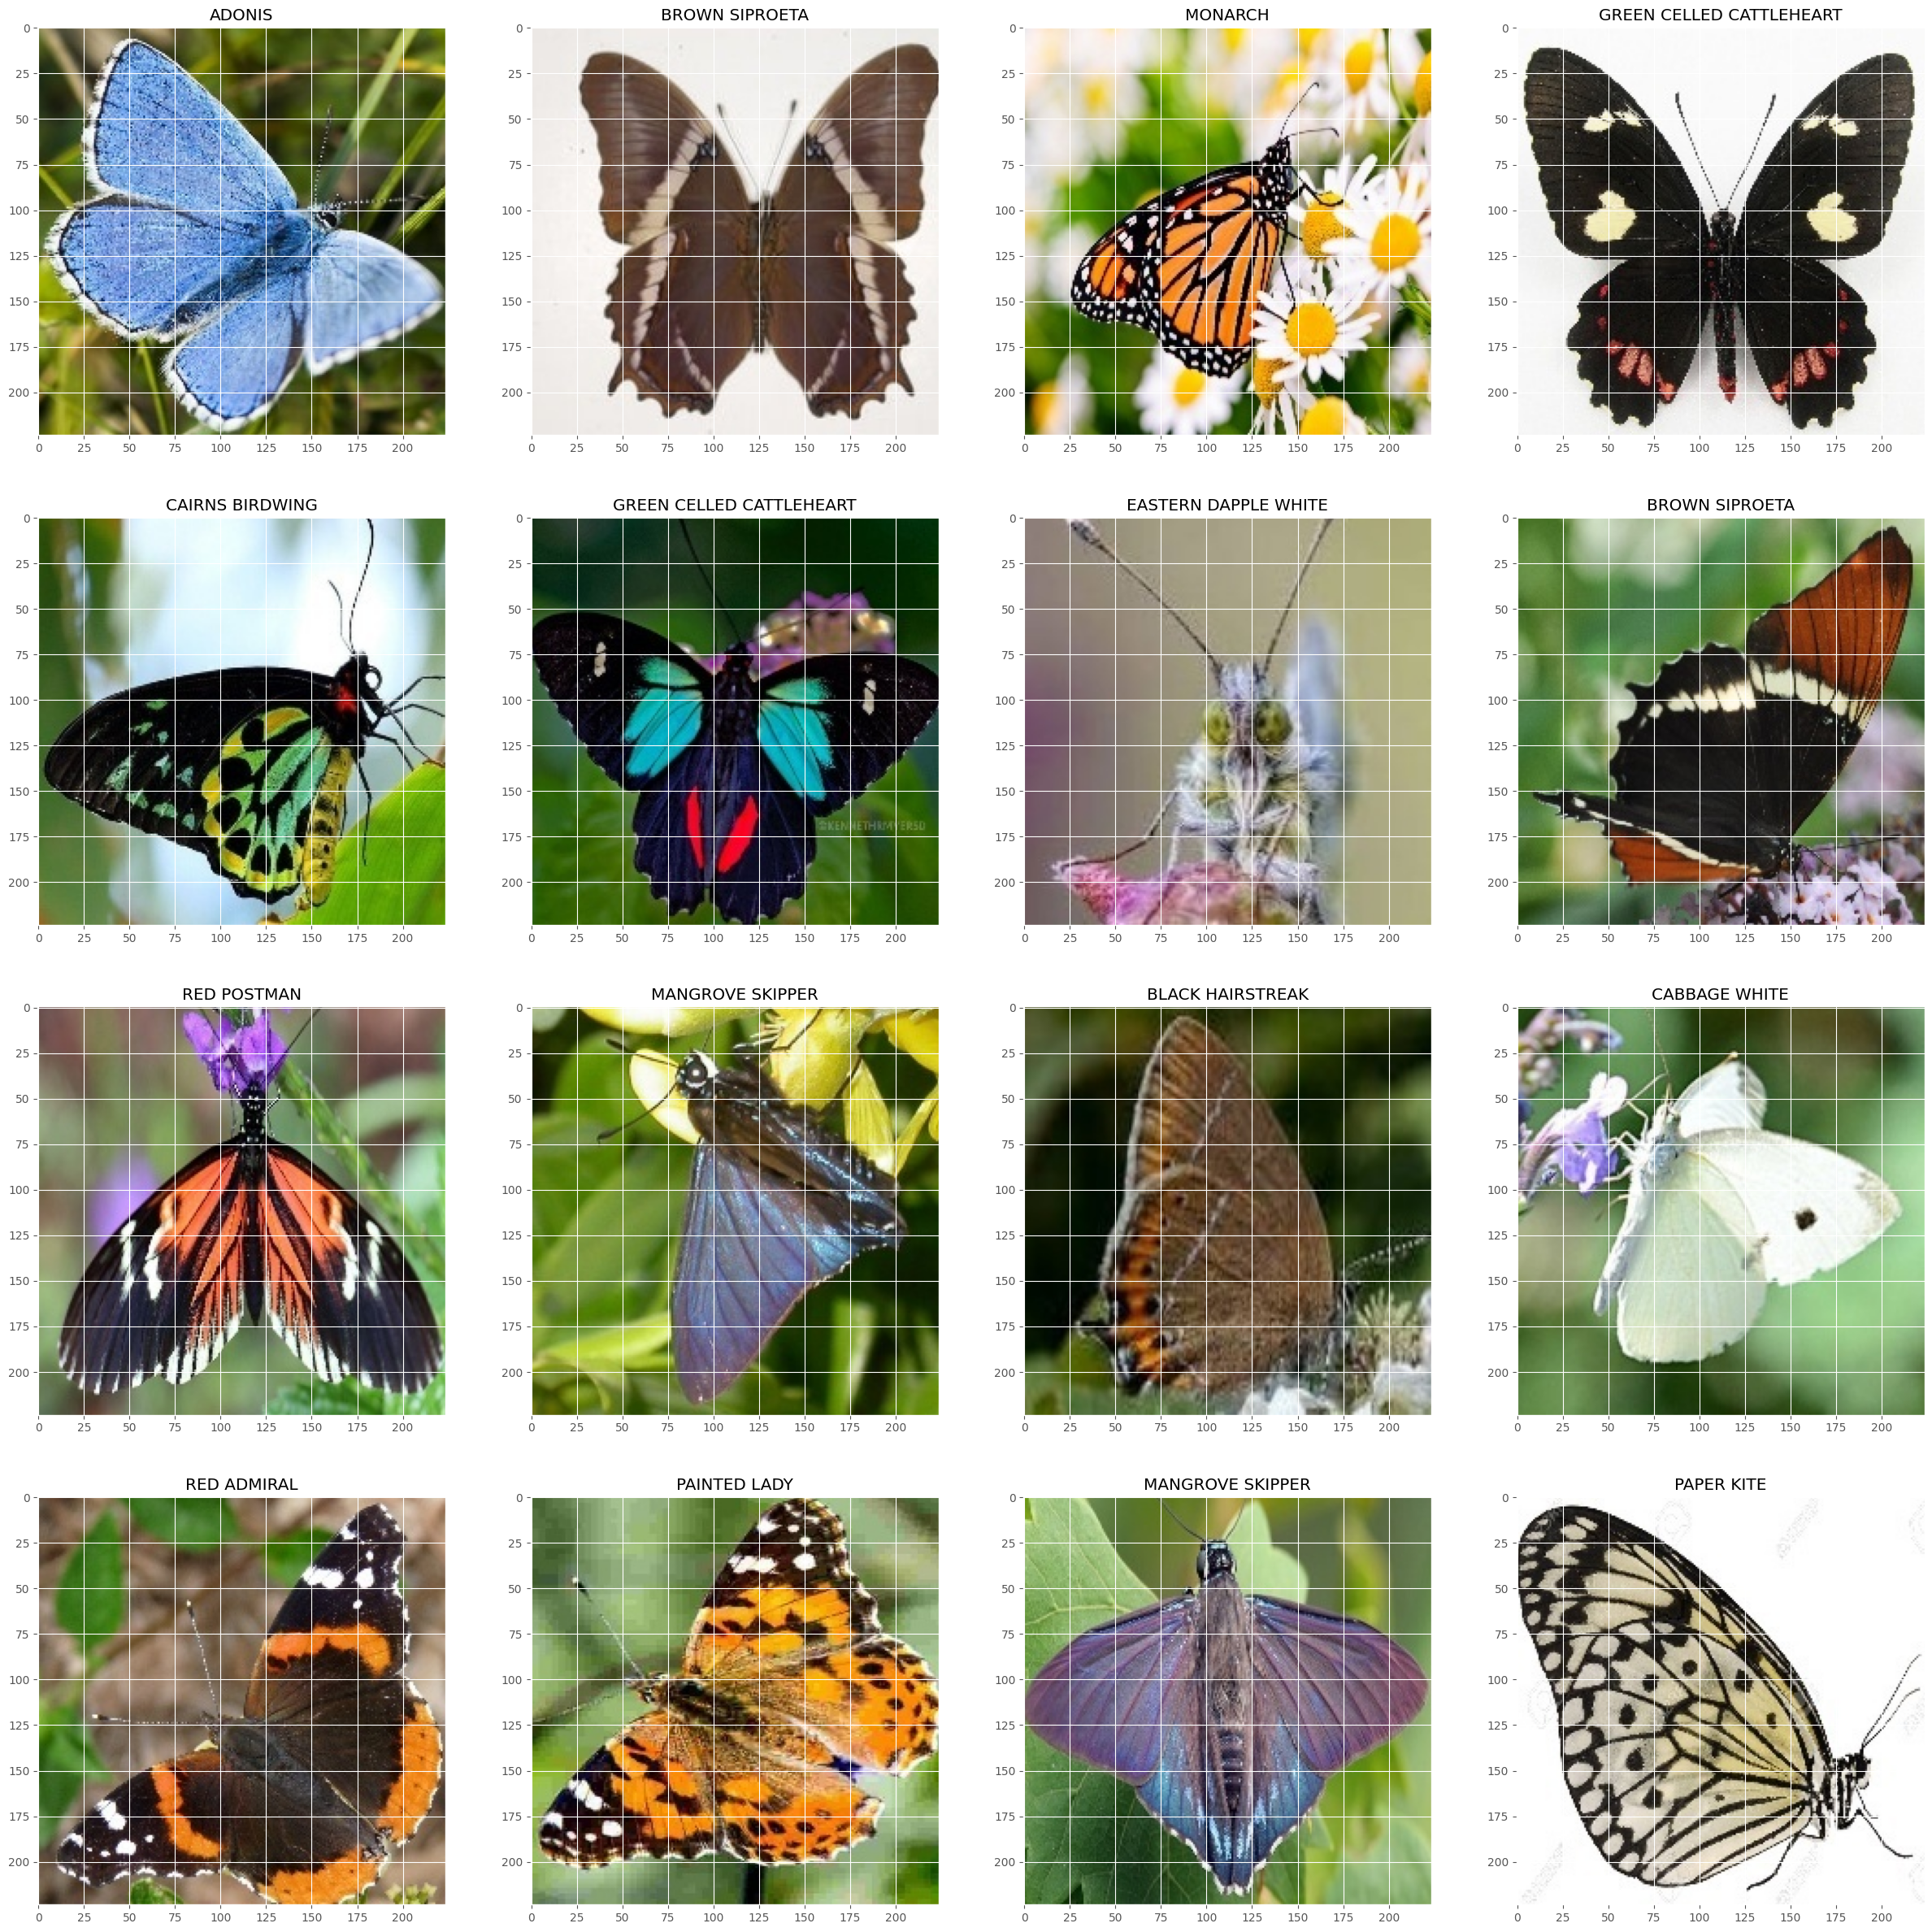

In [73]:
rows, cols = 4, 4
ax , fig = plt.subplots(rows,cols , figsize=(30,30))
for i in range(1,rows * cols + 1):
    filename = train_df.iloc[i].filename
    label = train_df.iloc[i].label
    
    plt.subplot(rows, cols, i)
    plt.title(label)
    
    image = os.path.join(TRAIN_IMAGE_PATH, filename)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

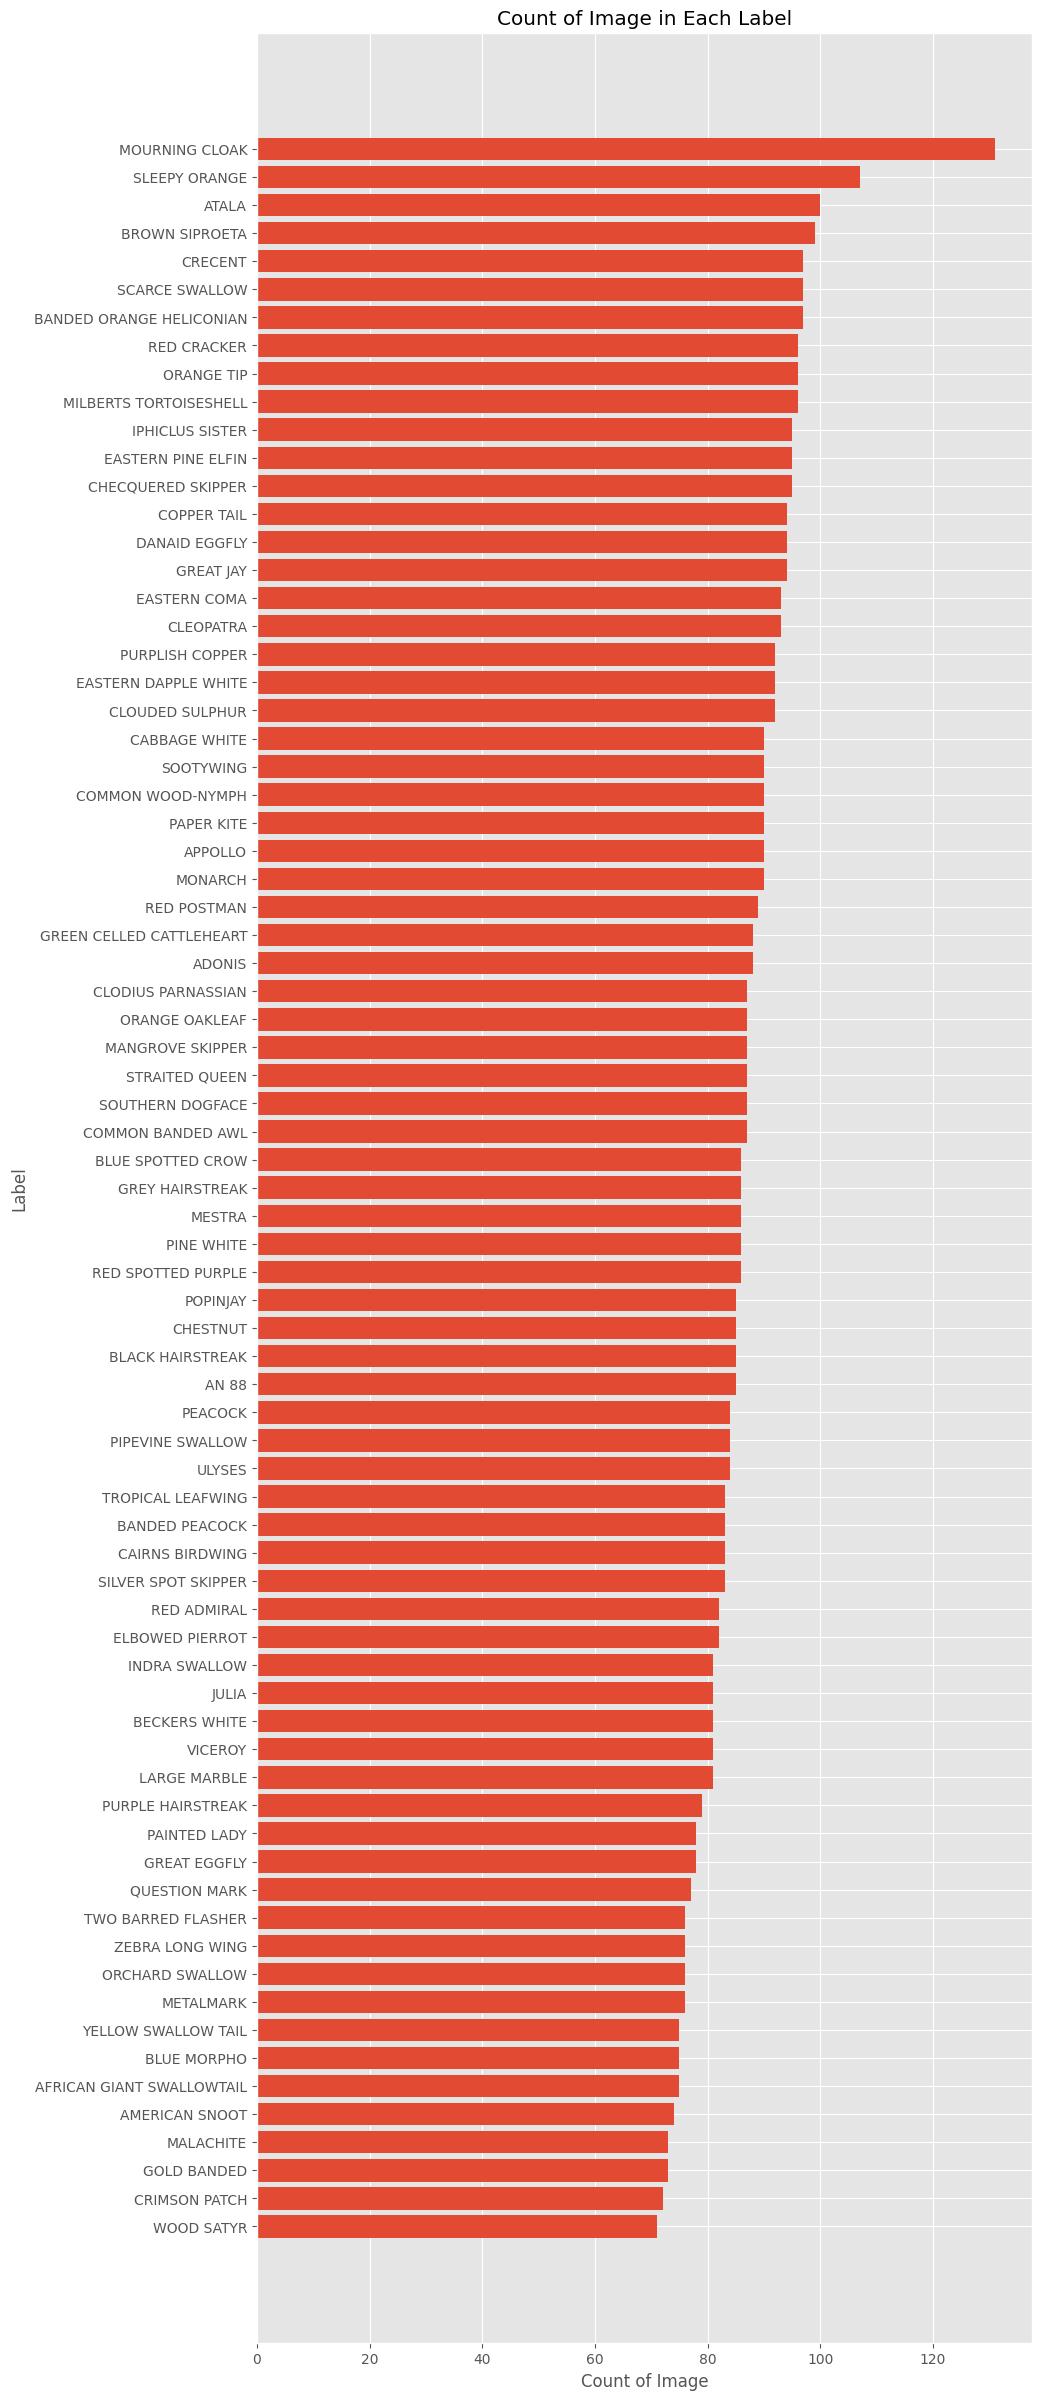

In [74]:
plt.figure(figsize=(10,30))
label_count = train_df['label'].value_counts().sort_values(ascending=True)
plt.barh(label_count.index, label_count.values)
plt.title("Count of Image in Each Label")
plt.xlabel("Count of Image")
plt.ylabel("Label")
plt.show()

In [75]:
print(f"The most common label is {label_count.index[-1]} and has {label_count[-1]} Images ")

The most common label is MOURNING CLOAK and has 131 Images 


In [76]:
print(f"The latest common label is {label_count.index[0]} and has {label_count[0]} Images ")

The latest common label is WOOD SATYR and has 71 Images 


In [21]:
class CustomDataset(Dataset):
    
    def __init__(self, train_df, trans, image_dir):
        
        self.image_dir = image_dir
        self.train_df = train_df
        self.trans = trans
    
    def __len__(self):
        
        return len(self.train_df)
    
    def __getitem__(self,index):
        
        image_path = os.path.join(self.image_dir,self.train_df.iloc[index].filename )
        
        image = cv2.imread(image_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
        if self.trans is not None:
            image = self.trans(image)
            
        label = self.train_df.iloc[index].label
        return image, label

In [22]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


val_transfrom = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [23]:
le = LabelEncoder()
encoded_labels = le.fit_transform(train_df['label'])
train_df['label'] = encoded_labels

In [24]:
class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

In [25]:
train_data, val_data = train_test_split(train_df  , test_size=0.2, stratify=encoded_labels)

In [26]:
train_data = CustomDataset(train_data, my_transforms, TRAIN_IMAGE_PATH)
val_data = CustomDataset(val_data, val_transfrom, TRAIN_IMAGE_PATH)

In [27]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,num_workers=2 , shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=2 ,shuffle=False)

In [354]:
sample = next(iter(val_loader))
sample[1]

tensor([31, 32, 66, 53, 38, 54, 34, 65,  8, 11, 15, 40, 39, 58,  6, 17, 35, 66,
        16, 71, 68, 14,  3, 38,  4, 64, 39, 23, 61, 35, 62, 22,  1, 21, 28, 25,
        20,  7, 10, 66, 22, 14, 35, 38, 31, 66, 15, 12,  8, 41, 53, 59, 15, 43,
        60, 43, 33, 23, 69, 62, 36, 39, 57, 51, 59, 57,  5, 26, 32,  1, 29, 23,
        23, 20, 55, 17, 48, 57, 40, 67, 39, 67,  5, 67, 32, 12, 36, 64, 56, 11,
        59, 18, 58, 22, 70, 64, 17, 62, 39, 65,  1, 47, 72, 28, 26, 51, 60,  8,
        63, 23, 55, 53, 46, 23, 22, 19, 72, 17, 61, 57, 32, 31, 50, 32, 51, 68,
        70, 37])

In [26]:
sample = next(iter(train_loader))
sample[1]

tensor([ 9, 35, 25, 45, 14, 46, 66, 19,  9, 49, 44, 52, 53, 60, 35, 31, 19, 20,
         8, 14, 13, 29,  5, 34,  4, 11, 15, 73, 71, 72,  3, 50, 46, 67, 11,  6,
        47, 12, 10, 28,  6, 54, 72, 35, 34, 47, 38,  2, 12,  5, 14, 17, 69, 41,
        39,  0, 56, 14, 49, 59,  4, 59, 62, 44, 40, 13, 52,  7,  8, 15, 26, 26,
        41, 56, 68, 30, 18, 58, 65, 30, 17, 36, 27,  4, 70, 66, 28, 30, 17, 22,
        34, 72,  0, 61, 22, 55, 41, 47, 33,  9, 36, 15, 19, 58, 37, 64, 23, 13,
        67, 28, 23, 31, 48, 41, 25, 12, 61, 36, 57, 42, 31, 63, 49,  2, 60, 37,
        41, 36, 17, 29, 38,  3, 52,  8, 24, 43, 62, 73, 53, 32, 19, 45, 15, 58,
        57,  1, 40, 46, 64, 61, 39, 16, 70, 65, 66, 27, 63, 56,  3,  6, 51, 68,
         8,  1, 69, 46, 50, 26, 11, 53, 49, 25, 48, 20, 27, 74, 50, 73, 52, 32,
        51, 51, 50, 27, 10, 35, 24, 40, 43, 34, 29, 26,  3, 44, 18, 42, 58, 72,
        69, 39, 74, 36, 12, 29, 29, 20, 27, 57, 28, 64, 19, 59, 40, 29, 14, 15,
        35, 70, 25, 50, 51, 39, 66, 18, 

In [27]:
# label_encoder = {label: id for id, label in enumerate(set(train_df.label.unique()))}
# label_encoder

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/effnet_comparison.png)

In [28]:
# base_model = EfficientNet.from_pretrained('efficientnet-b6')

In [54]:
# tensor = torch.ones((2,3 , 224, 224))
# base_model.extract_features(tensor).shape



In [28]:
class CustomModel(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5')
        
        for param in self.base_model.parameters():
            param.requires_grad  = False
        
        num_features = self.base_model._fc.in_features
        
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.attention = nn.Linear(num_features, num_features)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc3 = nn.Linear(1024, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)

        self.fc5 = nn.Linear(512, num_classes)
        
    def forward(self, data):
        
        net = self.base_model.extract_features(data)
        
        net = self.avgpool(net).squeeze()
        
        attention_weights = torch.sigmoid(self.attention(net))
        attention_weights = attention_weights.view(net.size(0), -1)

        attended_features = net * attention_weights
        
        net = attended_features.view(attended_features.size(0) , -1)
        
        net = F.relu(self.fc1(net))
        net = self.bn1(net)
        net = self.dropout(net)
        
        net = F.relu(self.fc2(net))
        net = self.bn2(net)
        net = self.dropout(net)
        
        net = F.relu(self.fc3(net))
        net = self.bn3(net)
        net = self.dropout(net)
        
        net = F.relu(self.fc4(net))
        net = self.bn4(net)
        net = self.dropout(net)
        
        net = self.fc5(net)
        
        return net

In [246]:
model =CustomModel(75)

tensor = torch.ones((7,3 , 224, 224))
model(tensor).shape



Loaded pretrained weights for efficientnet-b5


torch.Size([7, 75])

In [29]:
class CustomModel(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.base_model = models.resnet50(pretrained=True)
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  

        for param in self.base_model.parameters():
            param.requires_grad = False
            
        
        self.attention = nn.Linear(num_features, 1)
        
        self.fc1 = nn.Linear(num_features, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        
        self.fc5 = nn.Linear(512, num_classes)

    def forward(self, data):
        net = self.base_model(data)

        net = net.view(net.size(0), -1)
        
        net1 = F.relu(self.fc1(net))
        net1 = self.bn1(net1)
        net1 = self.dropout(net1)
        net2 = F.relu(self.fc2(net1))
        net2 = self.bn2(net2)
        net2 = self.dropout(net2)
        net4 = F.relu(self.fc4(net2))
        net4 = self.bn4(net4)
        net4 = self.dropout(net4)
        net5 = self.fc5(net4)

        return net5

In [30]:
model = CustomModel(NUM_CLASSES)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=8, verbose=True)


f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES).to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.2MB/s]


In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == True)

count = count_parameters(model)
print (count / 1000000)

3.71822


In [32]:
def compute_accuracy(model_output, labels):
    _, predicted_labels = torch.max(model_output, dim=1)
    correct_predictions = (predicted_labels == labels).sum().item()
    total_predictions = labels.size(0)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [33]:
def train_fn(model, data_loader, loss_fn, optimizer, device):
    # set model into training mode
    model = model.train()
    loss_sum = 0
    accuracy = []
    progress_bar = tqdm(data_loader)
#     progress_bar = data_loader
    for data in progress_bar:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        model_output = model(images)

        loss = loss_fn(model_output, labels)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        loss_sum += loss.item()
        model_output = torch.softmax(model_output, dim=1)
        _ , preds = torch.max(model_output, dim=1)
        accuracy.append(f1(preds, labels).item())
        
    epoch_loss = loss_sum / len(data_loader)
    return epoch_loss , optimizer.param_groups[0]["lr"] , np.mean(accuracy)  


def eval_fn(model, loss_fn, data_loader, device, scheduler):
    # set model into evalution mode

    model = model.eval()
    accuracy = []
    loss_sum = 0
    
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            model_output = model(images)
            
            loss = loss_fn(model_output, labels)
            
            loss_sum += loss.item()
    
            model_output = torch.softmax(model_output, dim=1)
            _ , preds = torch.max(model_output, dim=1)
            accuracy.append(f1(preds, labels).item())
        
        val_loss = loss_sum/ len(data_loader)
        scheduler.step(val_loss)

        return val_loss , np.mean(accuracy) 


In [34]:
for epoch in range(NUM_EPOCHS):
    
    print(f'Epoch : {epoch + 1}/{NUM_EPOCHS} .')

    training_loss , current_lr, train_accuracy = train_fn(model=model, data_loader=train_loader, loss_fn=loss_fn,
                                    optimizer=optimizer, device=device)
    
    val_loss , validation_accuracy = eval_fn(model,loss_fn, val_loader, device,  scheduler= scheduler)

    print("- Training Loss is : ", round(training_loss, 2) , f"     | Training Accuracy is {round(train_accuracy , 2)}"  )
    print("- Validation Loss is ",round(val_loss,2),"     | Validation Accuracy is : ", round(validation_accuracy, 2))
    print("- LR is " , current_lr)
    print("\n ------------------------ \n")

Epoch : 1/60 .


100%|██████████| 41/41 [00:28<00:00,  1.46it/s]


- Training Loss is :  2.95      | Training Accuracy is 0.29
- Validation Loss is  1.52      | Validation Accuracy is :  0.58
- LR is  0.01

 ------------------------ 

Epoch : 2/60 .


100%|██████████| 41/41 [00:11<00:00,  3.48it/s]


- Training Loss is :  1.59      | Training Accuracy is 0.56
- Validation Loss is  1.06      | Validation Accuracy is :  0.72
- LR is  0.01

 ------------------------ 

Epoch : 3/60 .


100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


- Training Loss is :  1.21      | Training Accuracy is 0.66
- Validation Loss is  0.85      | Validation Accuracy is :  0.75
- LR is  0.01

 ------------------------ 

Epoch : 4/60 .


100%|██████████| 41/41 [00:12<00:00,  3.28it/s]


- Training Loss is :  1.01      | Training Accuracy is 0.7
- Validation Loss is  0.81      | Validation Accuracy is :  0.76
- LR is  0.01

 ------------------------ 

Epoch : 5/60 .


100%|██████████| 41/41 [00:13<00:00,  3.11it/s]


- Training Loss is :  0.88      | Training Accuracy is 0.74
- Validation Loss is  0.74      | Validation Accuracy is :  0.8
- LR is  0.01

 ------------------------ 

Epoch : 6/60 .


100%|██████████| 41/41 [00:11<00:00,  3.42it/s]


- Training Loss is :  0.78      | Training Accuracy is 0.76
- Validation Loss is  0.61      | Validation Accuracy is :  0.81
- LR is  0.01

 ------------------------ 

Epoch : 7/60 .


100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


- Training Loss is :  0.7      | Training Accuracy is 0.79
- Validation Loss is  0.66      | Validation Accuracy is :  0.81
- LR is  0.01

 ------------------------ 

Epoch : 8/60 .


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


- Training Loss is :  0.65      | Training Accuracy is 0.8
- Validation Loss is  0.59      | Validation Accuracy is :  0.82
- LR is  0.01

 ------------------------ 

Epoch : 9/60 .


100%|██████████| 41/41 [00:12<00:00,  3.35it/s]


- Training Loss is :  0.63      | Training Accuracy is 0.81
- Validation Loss is  0.57      | Validation Accuracy is :  0.83
- LR is  0.01

 ------------------------ 

Epoch : 10/60 .


100%|██████████| 41/41 [00:11<00:00,  3.43it/s]


- Training Loss is :  0.57      | Training Accuracy is 0.83
- Validation Loss is  0.63      | Validation Accuracy is :  0.82
- LR is  0.01

 ------------------------ 

Epoch : 11/60 .


100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


- Training Loss is :  0.56      | Training Accuracy is 0.83
- Validation Loss is  0.57      | Validation Accuracy is :  0.83
- LR is  0.01

 ------------------------ 

Epoch : 12/60 .


100%|██████████| 41/41 [00:11<00:00,  3.45it/s]


- Training Loss is :  0.54      | Training Accuracy is 0.83
- Validation Loss is  0.57      | Validation Accuracy is :  0.83
- LR is  0.01

 ------------------------ 

Epoch : 13/60 .


100%|██████████| 41/41 [00:12<00:00,  3.29it/s]


- Training Loss is :  0.52      | Training Accuracy is 0.84
- Validation Loss is  0.55      | Validation Accuracy is :  0.83
- LR is  0.01

 ------------------------ 

Epoch : 14/60 .


100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


- Training Loss is :  0.49      | Training Accuracy is 0.84
- Validation Loss is  0.54      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 15/60 .


100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


- Training Loss is :  0.47      | Training Accuracy is 0.85
- Validation Loss is  0.53      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 16/60 .


100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


- Training Loss is :  0.48      | Training Accuracy is 0.85
- Validation Loss is  0.52      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 17/60 .


100%|██████████| 41/41 [00:12<00:00,  3.40it/s]


- Training Loss is :  0.47      | Training Accuracy is 0.85
- Validation Loss is  0.52      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 18/60 .


100%|██████████| 41/41 [00:11<00:00,  3.47it/s]


- Training Loss is :  0.44      | Training Accuracy is 0.85
- Validation Loss is  0.54      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 19/60 .


100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


- Training Loss is :  0.43      | Training Accuracy is 0.86
- Validation Loss is  0.5      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 20/60 .


100%|██████████| 41/41 [00:12<00:00,  3.31it/s]


- Training Loss is :  0.42      | Training Accuracy is 0.86
- Validation Loss is  0.55      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 21/60 .


100%|██████████| 41/41 [00:12<00:00,  3.37it/s]


- Training Loss is :  0.43      | Training Accuracy is 0.86
- Validation Loss is  0.55      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 22/60 .


100%|██████████| 41/41 [00:11<00:00,  3.45it/s]


- Training Loss is :  0.4      | Training Accuracy is 0.87
- Validation Loss is  0.57      | Validation Accuracy is :  0.83
- LR is  0.01

 ------------------------ 

Epoch : 23/60 .


100%|██████████| 41/41 [00:11<00:00,  3.53it/s]


- Training Loss is :  0.41      | Training Accuracy is 0.87
- Validation Loss is  0.52      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 24/60 .


100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


- Training Loss is :  0.4      | Training Accuracy is 0.87
- Validation Loss is  0.54      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 25/60 .


100%|██████████| 41/41 [00:11<00:00,  3.43it/s]


- Training Loss is :  0.39      | Training Accuracy is 0.87
- Validation Loss is  0.54      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 26/60 .


100%|██████████| 41/41 [00:12<00:00,  3.28it/s]


- Training Loss is :  0.36      | Training Accuracy is 0.88
- Validation Loss is  0.54      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 27/60 .


100%|██████████| 41/41 [00:11<00:00,  3.46it/s]


- Training Loss is :  0.37      | Training Accuracy is 0.88
- Validation Loss is  0.5      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 28/60 .


100%|██████████| 41/41 [00:11<00:00,  3.61it/s]


- Training Loss is :  0.37      | Training Accuracy is 0.88
- Validation Loss is  0.52      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 29/60 .


100%|██████████| 41/41 [00:12<00:00,  3.28it/s]


- Training Loss is :  0.37      | Training Accuracy is 0.88
- Validation Loss is  0.54      | Validation Accuracy is :  0.87
- LR is  0.01

 ------------------------ 

Epoch : 30/60 .


100%|██████████| 41/41 [00:11<00:00,  3.47it/s]


- Training Loss is :  0.37      | Training Accuracy is 0.88
- Validation Loss is  0.5      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 31/60 .


100%|██████████| 41/41 [00:11<00:00,  3.55it/s]


- Training Loss is :  0.33      | Training Accuracy is 0.9
- Validation Loss is  0.5      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 32/60 .


100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


- Training Loss is :  0.33      | Training Accuracy is 0.89
- Validation Loss is  0.51      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 33/60 .


100%|██████████| 41/41 [00:11<00:00,  3.44it/s]


- Training Loss is :  0.32      | Training Accuracy is 0.89
- Validation Loss is  0.54      | Validation Accuracy is :  0.84
- LR is  0.01

 ------------------------ 

Epoch : 34/60 .


100%|██████████| 41/41 [00:12<00:00,  3.26it/s]


- Training Loss is :  0.36      | Training Accuracy is 0.89
- Validation Loss is  0.5      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 35/60 .


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


- Training Loss is :  0.34      | Training Accuracy is 0.89
- Validation Loss is  0.49      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 36/60 .


100%|██████████| 41/41 [00:12<00:00,  3.28it/s]


- Training Loss is :  0.35      | Training Accuracy is 0.88
- Validation Loss is  0.54      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 37/60 .


100%|██████████| 41/41 [00:12<00:00,  3.38it/s]


- Training Loss is :  0.32      | Training Accuracy is 0.9
- Validation Loss is  0.51      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 38/60 .


100%|██████████| 41/41 [00:13<00:00,  3.09it/s]


- Training Loss is :  0.32      | Training Accuracy is 0.9
- Validation Loss is  0.51      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 39/60 .


100%|██████████| 41/41 [00:12<00:00,  3.34it/s]


- Training Loss is :  0.31      | Training Accuracy is 0.89
- Validation Loss is  0.48      | Validation Accuracy is :  0.87
- LR is  0.01

 ------------------------ 

Epoch : 40/60 .


100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


- Training Loss is :  0.33      | Training Accuracy is 0.89
- Validation Loss is  0.5      | Validation Accuracy is :  0.87
- LR is  0.01

 ------------------------ 

Epoch : 41/60 .


100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


- Training Loss is :  0.3      | Training Accuracy is 0.9
- Validation Loss is  0.49      | Validation Accuracy is :  0.87
- LR is  0.01

 ------------------------ 

Epoch : 42/60 .


100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


- Training Loss is :  0.31      | Training Accuracy is 0.9
- Validation Loss is  0.54      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 43/60 .


100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


- Training Loss is :  0.32      | Training Accuracy is 0.9
- Validation Loss is  0.51      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 44/60 .


100%|██████████| 41/41 [00:12<00:00,  3.24it/s]


- Training Loss is :  0.3      | Training Accuracy is 0.9
- Validation Loss is  0.53      | Validation Accuracy is :  0.85
- LR is  0.01

 ------------------------ 

Epoch : 45/60 .


100%|██████████| 41/41 [00:11<00:00,  3.43it/s]


- Training Loss is :  0.34      | Training Accuracy is 0.89
- Validation Loss is  0.5      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 46/60 .


100%|██████████| 41/41 [00:12<00:00,  3.31it/s]


- Training Loss is :  0.31      | Training Accuracy is 0.9
- Validation Loss is  0.52      | Validation Accuracy is :  0.88
- LR is  0.01

 ------------------------ 

Epoch : 47/60 .


100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


- Training Loss is :  0.29      | Training Accuracy is 0.91
- Validation Loss is  0.6      | Validation Accuracy is :  0.86
- LR is  0.01

 ------------------------ 

Epoch : 48/60 .


100%|██████████| 41/41 [00:12<00:00,  3.35it/s]


Epoch 00048: reducing learning rate of group 0 to 1.0000e-03.
- Training Loss is :  0.29      | Training Accuracy is 0.9
- Validation Loss is  0.53      | Validation Accuracy is :  0.88
- LR is  0.01

 ------------------------ 

Epoch : 49/60 .


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


- Training Loss is :  0.26      | Training Accuracy is 0.91
- Validation Loss is  0.52      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 50/60 .


100%|██████████| 41/41 [00:12<00:00,  3.38it/s]


- Training Loss is :  0.23      | Training Accuracy is 0.92
- Validation Loss is  0.48      | Validation Accuracy is :  0.88
- LR is  0.001

 ------------------------ 

Epoch : 51/60 .


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


- Training Loss is :  0.21      | Training Accuracy is 0.93
- Validation Loss is  0.49      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 52/60 .


100%|██████████| 41/41 [00:12<00:00,  3.26it/s]


- Training Loss is :  0.22      | Training Accuracy is 0.93
- Validation Loss is  0.48      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 53/60 .


100%|██████████| 41/41 [00:11<00:00,  3.44it/s]


- Training Loss is :  0.19      | Training Accuracy is 0.93
- Validation Loss is  0.48      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 54/60 .


100%|██████████| 41/41 [00:12<00:00,  3.23it/s]


- Training Loss is :  0.19      | Training Accuracy is 0.93
- Validation Loss is  0.47      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 55/60 .


100%|██████████| 41/41 [00:12<00:00,  3.37it/s]


- Training Loss is :  0.18      | Training Accuracy is 0.94
- Validation Loss is  0.47      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 56/60 .


100%|██████████| 41/41 [00:12<00:00,  3.36it/s]


- Training Loss is :  0.18      | Training Accuracy is 0.94
- Validation Loss is  0.48      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 57/60 .


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


- Training Loss is :  0.19      | Training Accuracy is 0.94
- Validation Loss is  0.49      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 58/60 .


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


- Training Loss is :  0.17      | Training Accuracy is 0.94
- Validation Loss is  0.48      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 59/60 .


100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


- Training Loss is :  0.17      | Training Accuracy is 0.94
- Validation Loss is  0.47      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 

Epoch : 60/60 .


100%|██████████| 41/41 [00:12<00:00,  3.42it/s]


- Training Loss is :  0.17      | Training Accuracy is 0.94
- Validation Loss is  0.46      | Validation Accuracy is :  0.89
- LR is  0.001

 ------------------------ 



In [56]:
model.eval()
accuracy = []
loss_sum = 0
pred_list = []
label_list = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        model_output = model(images)

        loss = loss_fn(model_output, labels)

        loss_sum += loss.item()

        model_output = torch.softmax(model_output, dim=1)
        _ , preds = torch.max(model_output, dim=1)
        accuracy.append(f1(preds, labels).item())
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()
        for i in range(len(preds)):
            pred_list.append(preds[i])
            label_list.append(labels[i])
            
            
        
print(f"Loss is {round(loss_sum / len(val_loader) , 2)}")
precision = precision_score(label_list, pred_list, average="micro")
recall = recall_score(label_list, pred_list, average="micro")
print(f"Precision is {round(precision,2)}")
print(f"Recall is {round(recall, 2)}")
print(f"F1 Score is {round(np.mean(accuracy) , 2)}")

Loss is 0.46
Precision is 0.89
Recall is 0.89
F1 Score is 0.89


### Vision Transformer

In [127]:
torch.cuda.empty_cache()

In [305]:
BATCH_SIZE = 256

In [306]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [307]:
# models.vit_l_16(pretrained=True).heads.head

In [363]:
class CustomVIT(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.base_model = models.vit_l_16(weights="ViT_L_16_Weights.IMAGENET1K_V1")
        
        self.base_model.heads.head = nn.Identity()
        
        
        for param in self.base_model.parameters():
            param.requires_grad  = False
            
            
        num_features = 1024
        
        
        
        self.fc1 = nn.Linear(num_features, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.5)
        
        
        self.fc2 = nn.Linear(1024, 512)
        
        
        self.classifer = nn.Linear(512,num_classes)
        
    
    def forward(self, data):
        
        net = self.base_model(data)
        
        net = F.relu(net)
        net = self.dropout(net)
        
        net = F.relu(self.fc1(net))
        net = self.bn1(net)
        net = self.dropout(net)
        
        net = F.relu(self.fc2(net))
        net = self.dropout(net)
        
        
        
        net = self.classifer(net)
        
        return net
        


In [364]:
vit_model = CustomVIT(NUM_CLASSES)
vit_model = vit_model.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)


f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES).to(device)


In [365]:
count = count_parameters(vit_model)
print (count / 1000000)

1.614923


In [ ]:
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    
    
    print(f'Epoch : {epoch + 1}/{NUM_EPOCHS} .')

    training_loss , current_lr, train_accuracy = train_fn(model=vit_model, data_loader=train_loader, loss_fn=loss_fn,
                                    optimizer=optimizer, device=device)
    
    val_loss , validation_accuracy = eval_fn(vit_model,loss_fn, val_loader, device,  scheduler= scheduler)

    print("- Training Loss is : ", round(training_loss, 2) , f"     | Training Accuracy is {round(train_accuracy , 2)}"  )
    print("- Validation Loss is ",round(val_loss,2),"     | Validation Accuracy is : ", round(validation_accuracy, 2))
    print("- LR is " , current_lr)
    print("\n ------------------------ \n")

Epoch : 1/20 .


 51%|█████     | 21/41 [00:52<00:49,  2.47s/it]